# Classify spam vs no spam emails

In [1]:
import tensorflow as tf 
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

Import the dataset (Dataset is taken from kaggle)

In [3]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [4]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [5]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [6]:
747/4825 #-->747/5572 

0.15481865284974095

15% spam emails, 85% ham emails: This indicates class imbalance

In [8]:
df_spam = df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [9]:
df_ham = df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [10]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])
df_ham_downsampled.shape

(747, 2)

In [11]:
df_balanced = pd.concat([df_ham_downsampled, df_spam])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [13]:
df_balanced['spam']=df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(5)

,Category,Message,spam
1993,spam,Free tones Hope you enjoyed your new content. ...,1
2823,spam,ROMCAPspam Everyone around should be respondin...,1
3361,ham,Please attend the phone:),0
924,ham,She went to attend another two rounds today..b...,0
2329,ham,That day you asked about anand number. Why:-),0


Split it into training and test data set

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'],df_balanced['spam'], stratify=df_balanced['spam'])

In [15]:
X_train.head(4)

5005    There's someone here that has a year  &lt;#&gt...
743     Just got up. have to be out of the room very s...
4386    Do you want a New Nokia 3510i Colour Phone Del...
1387                          All e best 4 ur exam later.
Name: Message, dtype: object

Now lets import BERT model and get embeding vectors for few sample statements

In [16]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [17]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up", 
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.84351677, -0.5132723 , -0.88845706, ..., -0.7474882 ,
        -0.7531471 ,  0.91964483],
       [-0.8720836 , -0.50543964, -0.9444667 , ..., -0.8584748 ,
        -0.7174535 ,  0.8808298 ]], dtype=float32)>

Get embeding vectors for few sample words. Compare them using cosine similarity

In [18]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [21]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911089]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different. Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [26]:
cosine_similarity([e[0]],[e[3]])

array([[0.8470384]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [27]:
cosine_similarity([e[3]],[e[4]])

array([[0.9872036]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

# Build Model


In [28]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [30]:
len(X_train)

1120

In [31]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

# Train the model

In [32]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
35/35 [==============================] - 89s 2s/step - loss: 0.6728 - accuracy: 0.5964 - precision: 0.6023 - recall: 0.5679
Epoch 2/10
35/35 [==============================] - 84s 2s/step - loss: 0.5442 - accuracy: 0.7804 - precision: 0.7574 - recall: 0.8250
Epoch 3/10
35/35 [==============================] - 85s 2s/step - loss: 0.4785 - accuracy: 0.8170 - precision: 0.8245 - recall: 0.8054
Epoch 4/10
35/35 [==============================] - 85s 2s/step - loss: 0.4180 - accuracy: 0.8679 - precision: 0.8540 - recall: 0.8875
Epoch 5/10
35/35 [==============================] - 88s 3s/step - loss: 0.3838 - accuracy: 0.8750 - precision: 0.8559 - recall: 0.9018
Epoch 6/10
35/35 [==============================] - 86s 2s/step - loss: 0.3591 - accuracy: 0.8804 - precision: 0.8672 - recall: 0.8982
Epoch 7/10
35/35 [==============================] - 87s 2s/step - loss: 0.3430 - accuracy: 0.8857 - precision: 0.8737 - recall: 0.9018
Epoch 8/10
35/35 [==============================] - 84s

In [33]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 30s 2s/step - loss: 0.2665 - accuracy: 0.9225 - precision: 0.9202 - recall: 0.9251


[0.26649558544158936,
 0.9224599003791809,
 0.9202127456665039,
 0.9251337051391602]

In [41]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [42]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,

In [43]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[172,  15],
       [ 14, 173]], dtype=int64)

Text(33.0, 0.5, 'Truth')

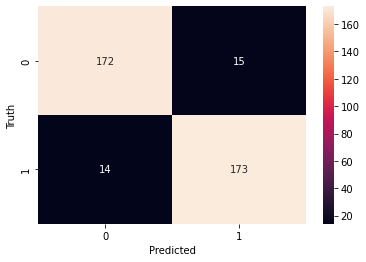

In [44]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [45]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92       187
           1       0.92      0.93      0.92       187

    accuracy                           0.92       374
   macro avg       0.92      0.92      0.92       374
weighted avg       0.92      0.92      0.92       374



# Inference

In [46]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.6563906 ],
       [0.8064789 ],
       [0.74751455],
       [0.17842036],
       [0.10172694]], dtype=float32)